# Map Analysis II

###  Renée Hložek and Jeff McMahon, edits by Elle Shaw
### This is based on the CMB S4 School Notebook 6

## Using our tools on real data

In this notebook, we are going to use some public data from the ACT collaboration, compute power spectra and compare them to theory power spectra, building off of what we learned yesterday.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
%matplotlib inline

In [2]:
#make sure to direct to the UT_Notebooks folder. 
%cd /Users/eshaw/box/UTAustin_CMBSummerSchool/UT_Notebooks/

import constants as cs # the constants module

from cmb_modules import * # the module of functions

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

C:\Users\eshaw\box\UTAustin_CMBSummerSchool\UT_Notebooks


# Reading in data and making simulated maps
Let's start by reading in a map and computing the power spectrum of the map, and then comparing to a theory map of a similar size/shape

0.49491833030853 0.49407681818181814
map mean: -3.5245380283448906 map rms: 311.228361194383


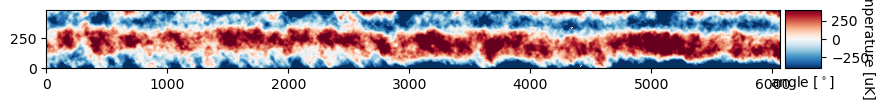

In [3]:
map = fits.getdata('ACT_Season3_148_GHz_submap.fits')
header = fits.getheader('ACT_Season3_148_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins
plt.figure(figsize=(10,10))
p = Plot_CMB_Map(map,c_min,c_max,Nx,Ny)


You can see that these ACT maps are long stripes, so we will cut a square patch out of the long strip and compute the PS on that patch.

map mean: 20.125159755016572 map rms: 124.47878213360549


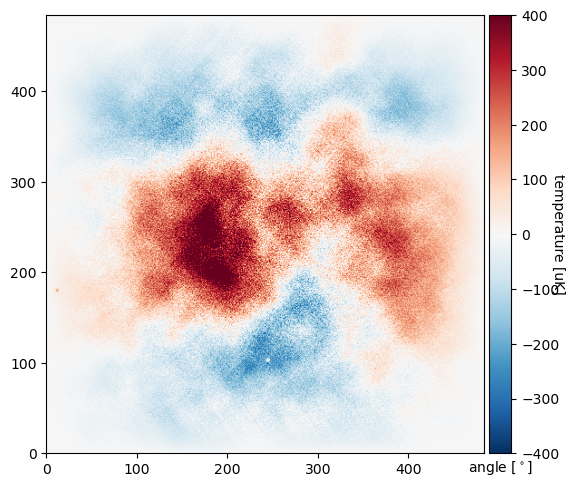

In [5]:
N=int(Ny) # take only one dimension
map_patch = map[0:int(N), 0:int(N)] #trimming the map down to size 
#Remember dimensions of these map are expressed (y,x) 


# Making a window function, taking the shorter dimension for now
window = (cosine_window(N))
appodized_map = window * map_patch
p=Plot_CMB_Map(appodized_map,c_min,c_max,N, N,figsize_x=6,figsize_y=6)


#### Q: We can see that there is a lot of power on large scales from the atmosphere. What do you think this will look like in the power spectrum?

[Your thoughts here]

Let's make a theory map as we have in many other modules:

Number of sources required:  5000
map mean: -10.529149283075979 map rms: 43.6219554671067


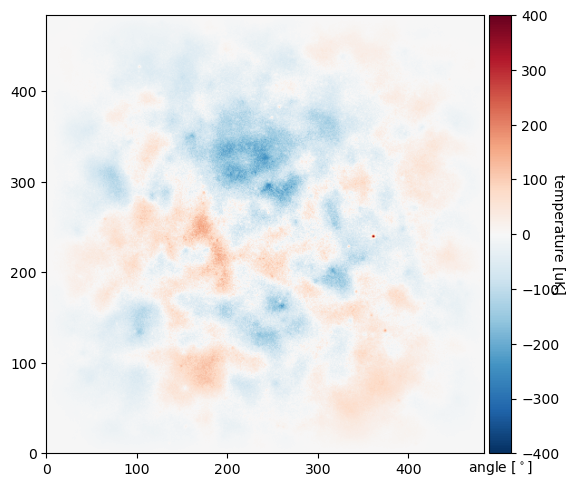

In [7]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 

CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorporate the impact of the instrument
    ## beam
CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
#p=Plot_CMB_Map(total_map_plus_noise,c_min,c_max,N,N)

appodized_theory_map = window * total_map_plus_noise

p=Plot_CMB_Map(appodized_theory_map,c_min,c_max,N, N,figsize_x=6,figsize_y=6)

### We will now take the power spectrum of this apodised map, and the theory version and compare

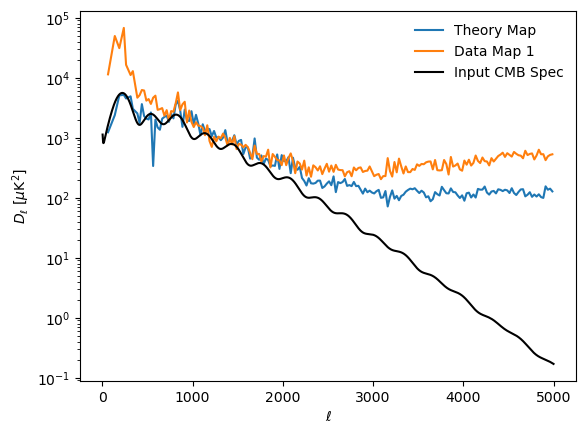

In [15]:
#### parameters for setting up the spectrum
delta_ell = 25.# cs.delta_ell
ell_max = int(cs.ell_max)
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')
        
binned_ell_theory, binned_spectrum_theory = \
    calculate_2d_spectrum(appodized_theory_map, delta_ell, ell_max, pix_size, N)
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(appodized_map, delta_ell, ell_max, pix_size, N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='Theory Map')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='Data Map 1')
#plt.clf()

plt.semilogy(ell,DlTT, 'k', label = 'Input CMB Spec')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
leg = plt.legend()
leg.draw_frame(False)
plt.show()

#### Q: What are differences you can see between the sim map spectra and the data spectra?

[Your thoughts here]

#### Q: Notice that the power spectrum is biased high on large (and smallest) scales -- as we expected it to be. How might you remove that large scale power before computing the power spectrum? Will the destriping functionality of "Filter_Map" be useful here? 

[Your thoughts here]

The Filter_Map_MultiMask function in cmb_modules.py has options for masking ell values radially in fourier space, (so annular bins) as well as the destriping functionality.

The arguments of the function are as follows: 

    def Filter_Map_MultiMask(Map, N, N_Xdestripe=0, N_Ydestripe=0, 
                            N_R_mask_min=0, N_R_mask_max=None, return_mask=False):
        """
        Filters a map by masking in fourier space. 
        Choose N_Xdestripe for destriping in X direction
        Choose N_Ydestripe for destriping in Y direction
        Choose N_R_mask* for general ell masking. 
            _min all 'ells' smaller than min are masked
            _max all 'ells' larger than max are masked
        return_mask: boolean, default False: but if you set it to True it will return you the mask you created.
        """
    ...

Use it to help you in the next few exercises. Try writing a script that will plot the generated mask. 

<font color='red'>EXERCISE 1: </font>  Write code to filter out the large scale modes ell < ell_min before computing the power spectrum and show the spectra for a few different values for N_mask.  (Suggestion: Start by plotting the 2D FFT of both maps to look at the noise in Fourier space). What shape of mask might you want to choose based on the 2DFFT of the map?

In [11]:
#Your code and plots here

<font color='red'>EXERCISE 2: </font> Think about how you might attempt to remove the ringing the power on small scales. Try a different appodization window and see how it affects your results. Discuss the shape of the apodising window and the large scale power leaking to small scales. 

In [12]:
#Your code and plots here

<font color='red'>EXCERCISE 3: </font>  We cut out a particular patch from the ACT strip above. Cut out different patches and view the maps. How many unique maps are there? Make a dictionary/array and fill it with all the maps.

In [13]:
#Your code and plots here

<font color='red'>EXCERCISE 4: </font>  Now you'll calculate the power spectra of all the different maps. 
By using the power spectrum code in the modules file, compute and plot both the auto and the cross spectra for the maps, along with the averages.

In [14]:
#Your code and plots here

In a cross spectrum between two independent maps of the same patch of sky, the mean noise bias is zero.

<$\hat D$> = <$T*D_{\ell} + N$> = <$T*D_{\ell}$>. 

Thus the mean of all the crosses gives an estimate of the true band power, and the rms of the crosses gives an estimate on the error bars, without the risk of bias from an incorrect noise model.

This isn't applicable here, since the maps made from the long ACT map strip aren't of the same sky, but it is cool.

<font color='red'>EXCERCISE 5: </font>
Lets make an estimate for the noise in the ACT maps by changing the noise levels injected into noise-only sims. Plot noise curves for a few values and show here. (Add noise_only_sims to some signal_only sims). Do a simple "by-eye" estimate of the noise level. What does that tell you about real-world noise from CMB Experiments?

Be careful if you copy code directly from Part_4, the definition of calculate_2d_spectrum is slightly different in the cmb_modules.py script than from yesterday.

In [6]:
# Your code here

Your discussion here

## Frequency dependence of maps and foregrounds

Now we are going to look at ACT maps on the same patch of the sky, but in a different frequency band.

0.49491833030853 0.49407681818181814
map mean: -35.148097186618045 map rms: 319.0813587167169


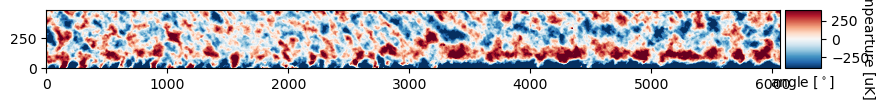

In [11]:
map220 = fits.getdata('ACT_Season3_220_GHz_submap.fits')
header = fits.getheader('ACT_Season3_220_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins
plt.figure(figsize=(10,10))
p = Plot_CMB_Map(map220,c_min,c_max,Nx,Ny)


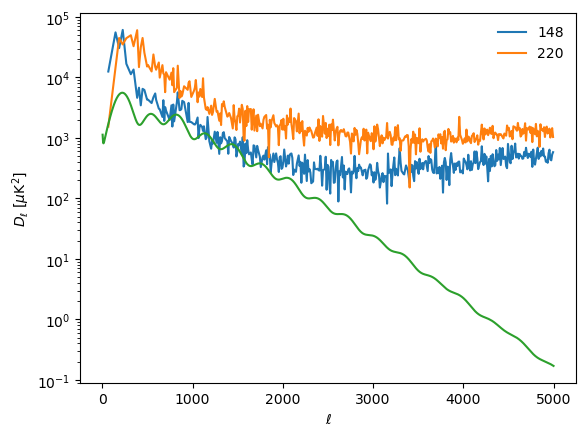

In [12]:
N=int(Ny) # take only one dimension
map_patch220 = map220[0:int(N), 0:int(N)] #trimming the map down to size
window = (cosine_window(N))
appodized_map220 = window * map_patch220

binned_ell_dat220, binned_spectrum_dat220 = calculate_2d_spectrum(appodized_map220,delta_ell,ell_max,pix_size,N)
plt.semilogy(binned_ell_dat,binned_spectrum_dat* binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='148')
plt.semilogy(binned_ell_dat220,binned_spectrum_dat220* binned_ell_dat220 * (binned_ell_dat220+1.)/2. / np.pi, label='220')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

<font color='red'>EXCERCISE 6: </font> The spectrum is biased high from point sources on all scales. Use the code from the previous notebook to determine the noise bias for this spectrum and remove it.

In [ ]:
## Your code here